In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

/tmp/ipykernel_1106172/1554338744.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/home/farbod.moghaddam/miniconda3/envs/cpu/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# get all files in processed and subdirectories
files = []
for root, dirs, filenames in os.walk('processed'):
    for filename in filenames:
        files.append(os.path.join(root, filename))
print(files)

files = [f for f in files if all(x not in f for x in ['chain_convergence', 'combined', 'chunked', 'hyperparameter_results'])]

# read all csv files and concatenate them into a single dataframe
dataframes = []
for file in files:
    if file.endswith('.csv'):
        df = pd.read_csv(file)
        # Extract the file name without path and extension
        base = os.path.basename(file)
        name = base[:base.rfind('_')]
        df['dataset'] = name
        dataframes.append(df)
data = pd.concat(dataframes, ignore_index=True)

data = data[["chain", "iter", "log_p", "dataset"]]
data = data.sort_values('log_p').drop_duplicates(subset=['dataset', 'iter', 'chain'], keep='first')
data = data.sort_values(['iter', 'dataset']).reset_index(drop=True)
data.to_csv('processed/combined.csv', index=False)
data

['processed/chain_convergence.csv', 'processed/chunked_data.csv', 'processed/combined.csv', 'processed/hyperparameter_results.csv', 'processed/convergence_comparison.csv', 'processed/windowed_data.csv', 'processed/runsNoT/run5p2wgs_chain2.csv', 'processed/runsNoT/run5p2wgs_chain1.csv', 'processed/runsNoT/run5p2wgs_chain3.csv', 'processed/runsNoT/run5p3wgs_chain1.csv', 'processed/runsNoT/run5p3wgs_chain2.csv', 'processed/runsNoT/run5p3wgs_chain4.csv', 'processed/runsNoT/run5p2wgs_chain4.csv', 'processed/runsNoT/run5p3wgs_chain3.csv', 'processed/runsNoT/run5p9wgs_chain3.csv', 'processed/runsNoT/run5p9wgs_chain2.csv', 'processed/runsNoT/run5p9wgs_chain1.csv', 'processed/runsNoT/run5p9wgs_chain4.csv', 'processed/runsWithT/run5p2wgs_t_chain1.csv', 'processed/runsWithT/run5p2wgs_t_chain2.csv', 'processed/runsWithT/run5p3wgs_t_chain2.csv', 'processed/runsWithT/run5p2wgs_t_chain3.csv', 'processed/runsWithT/run5p3wgs_t_chain1.csv', 'processed/runsWithT/run5p2wgs_t_chain4.csv', 'processed/runsWi

,chain,iter,log_p,dataset
0,1,0.0,-16827.303,run5p2wgs
1,3,0.0,-16827.303,run5p2wgs
2,0,0.0,-16827.303,run5p2wgs
3,2,0.0,-6870.875,run5p2wgs
4,1,0.0,-5873.049,run5p2wgs_t
...,...,...,...,...
12941,2,NaN,NaN,convergence
12942,1,NaN,NaN,windowed
12943,3,NaN,NaN,windowed
12944,0,NaN,NaN,windowed


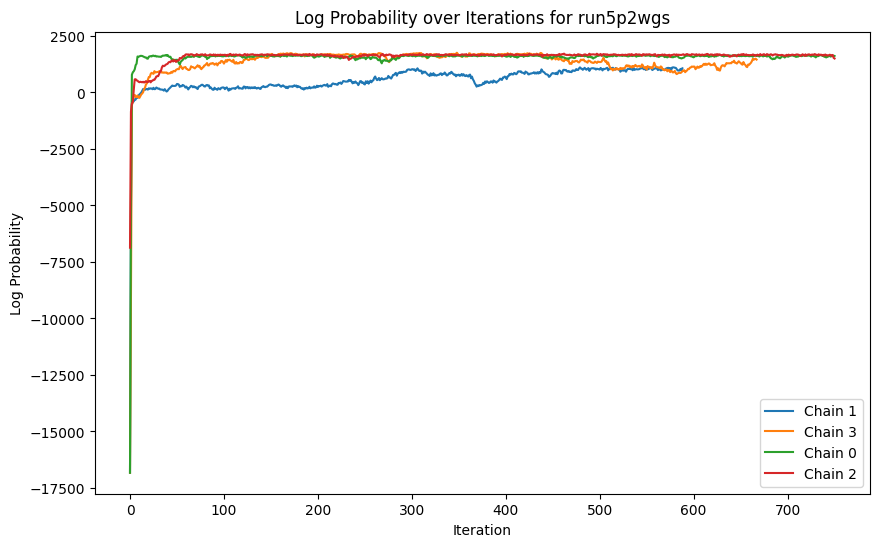

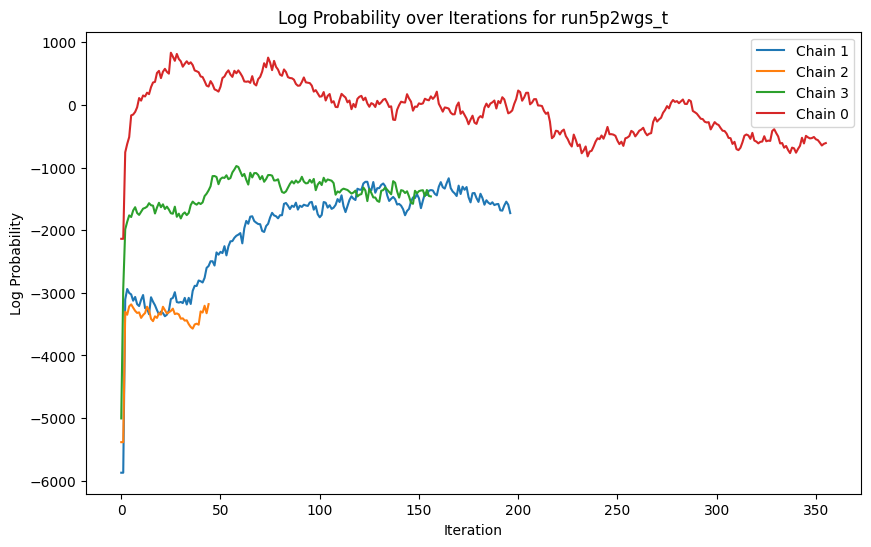

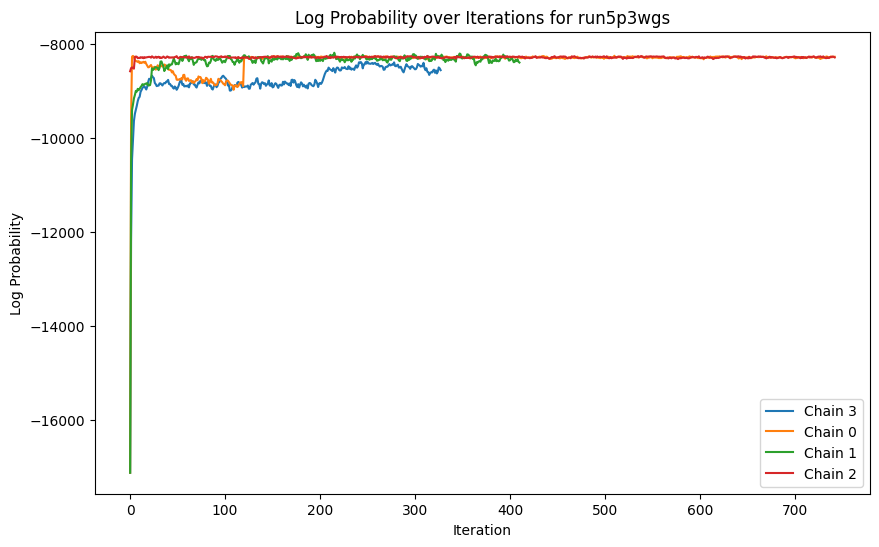

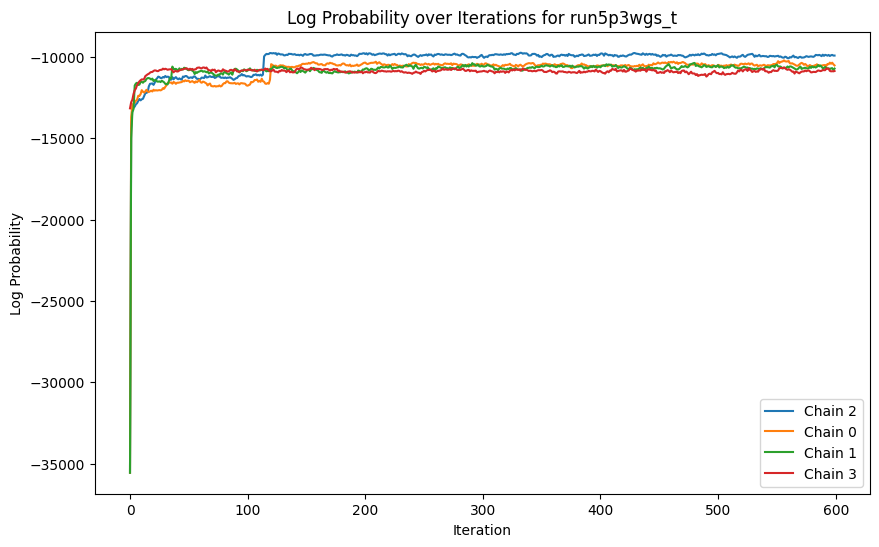

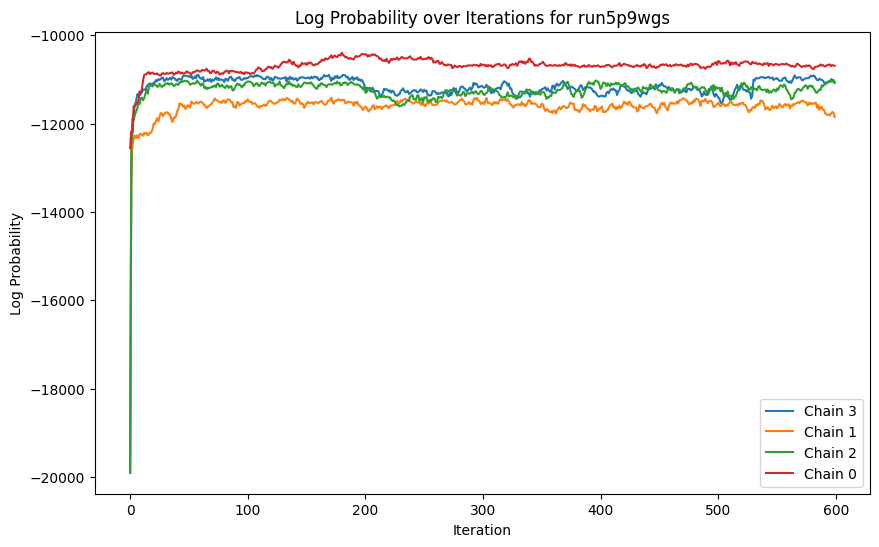

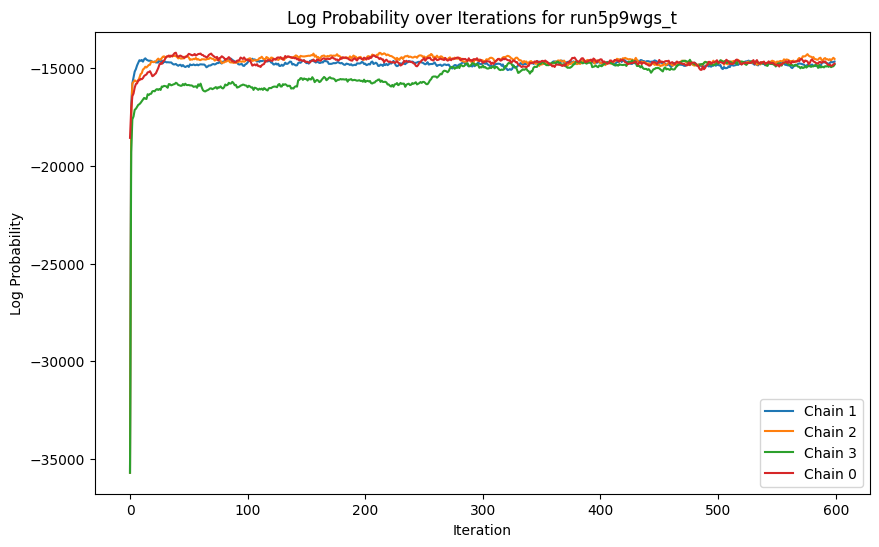

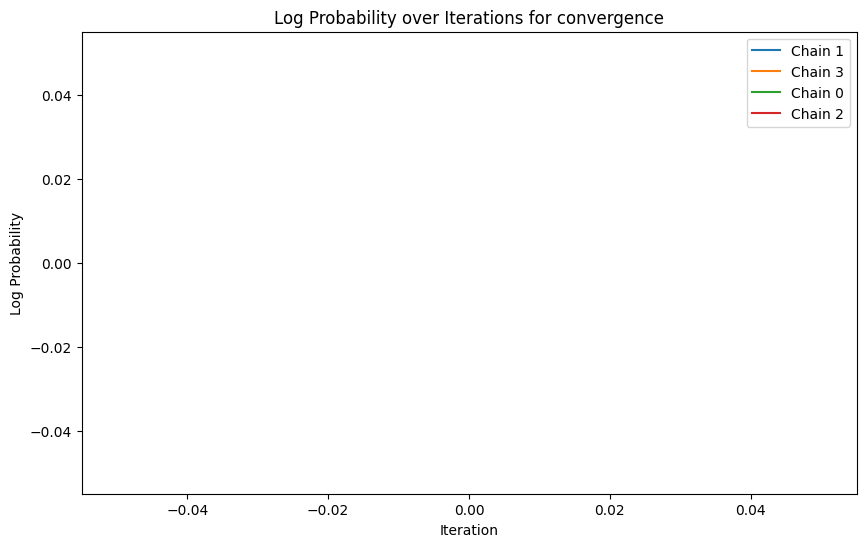

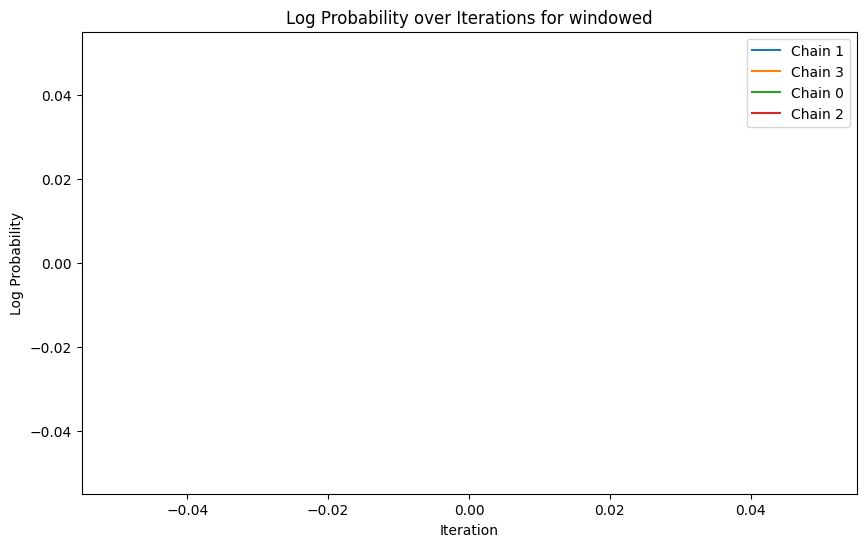

In [3]:
# plot the log_p values for each dataset
datasets = data['dataset'].unique()
for dataset in datasets:
    subset = data[data['dataset'] == dataset]
    plt.figure(figsize=(10, 6))
    for chain in subset['chain'].unique():
        chain_data = subset[subset['chain'] == chain]
        plt.plot(chain_data['iter'], chain_data['log_p'], label=f'Chain {chain}')
    plt.title(f'Log Probability over Iterations for {dataset}')
    plt.xlabel('Iteration')
    plt.ylabel('Log Probability')
    plt.legend()
    plt.show()

In [4]:
# Find when each chain reaches global maximum
tolerance_ratio = 0.015

results = []
for dataset in datasets:
    subset = data[data['dataset'] == dataset]
    global_max = subset['log_p'].max()
    global_min = subset['log_p'].min()
    log_p_range = global_max - global_min
    tolerance = abs(log_p_range * tolerance_ratio)  # Calculate tolerance as ratio of range
    
    for chain in subset['chain'].unique():
        chain_data = subset[subset['chain'] == chain].sort_values('iter')
        
        # Find first iteration where log_p is within tolerance of global max
        reached = chain_data[chain_data['log_p'] >= global_max - tolerance]
        
        if len(reached) > 0:
            iter_reached = reached['iter'].min()
        else:
            iter_reached = -1
        
        results.append({
            'dataset': dataset,
            'chain': chain,
            'global_max': global_max,
            'global_min': global_min,
            'log_p_range': log_p_range,
            'iter_reached': iter_reached,
            'max_log_p': chain_data['log_p'].max()
        })

results_df = pd.DataFrame(results)

# run5p2wgs_t does not reach the global maximum in any chain, so we can change its iter_reached to -1
results_df.loc[results_df['dataset'] == 'run5p2wgs_t', 'iter_reached'] = -1

# chain 0 for run5p3wgs reaches at iteration 120, so we can set it correctly
results_df.loc[(results_df['dataset'] == 'run5p3wgs') & (results_df['chain'] == 0), 'iter_reached'] = 120
results_df.to_csv('processed/chain_convergence.csv', index=False)
results_df

,dataset,chain,global_max,global_min,log_p_range,iter_reached,max_log_p
0,run5p2wgs,1,1755.493,-16827.303,18582.796,-1.0,1108.228
1,run5p2wgs,3,1755.493,-16827.303,18582.796,123.0,1755.493
2,run5p2wgs,0,1755.493,-16827.303,18582.796,8.0,1661.086
3,run5p2wgs,2,1755.493,-16827.303,18582.796,53.0,1716.349
4,run5p2wgs_t,1,833.760,-5873.049,6706.809,-1.0,-1171.283
5,run5p2wgs_t,2,833.760,-5873.049,6706.809,-1.0,-3181.008
6,run5p2wgs_t,3,833.760,-5873.049,6706.809,-1.0,-975.876
7,run5p2wgs_t,0,833.760,-5873.049,6706.809,-1.0,833.760
8,run5p3wgs,3,-8189.957,-17114.803,8924.846,-1.0,-8380.276
9,run5p3wgs,0,-8189.957,-17114.803,8924.846,120.0,-8255.091


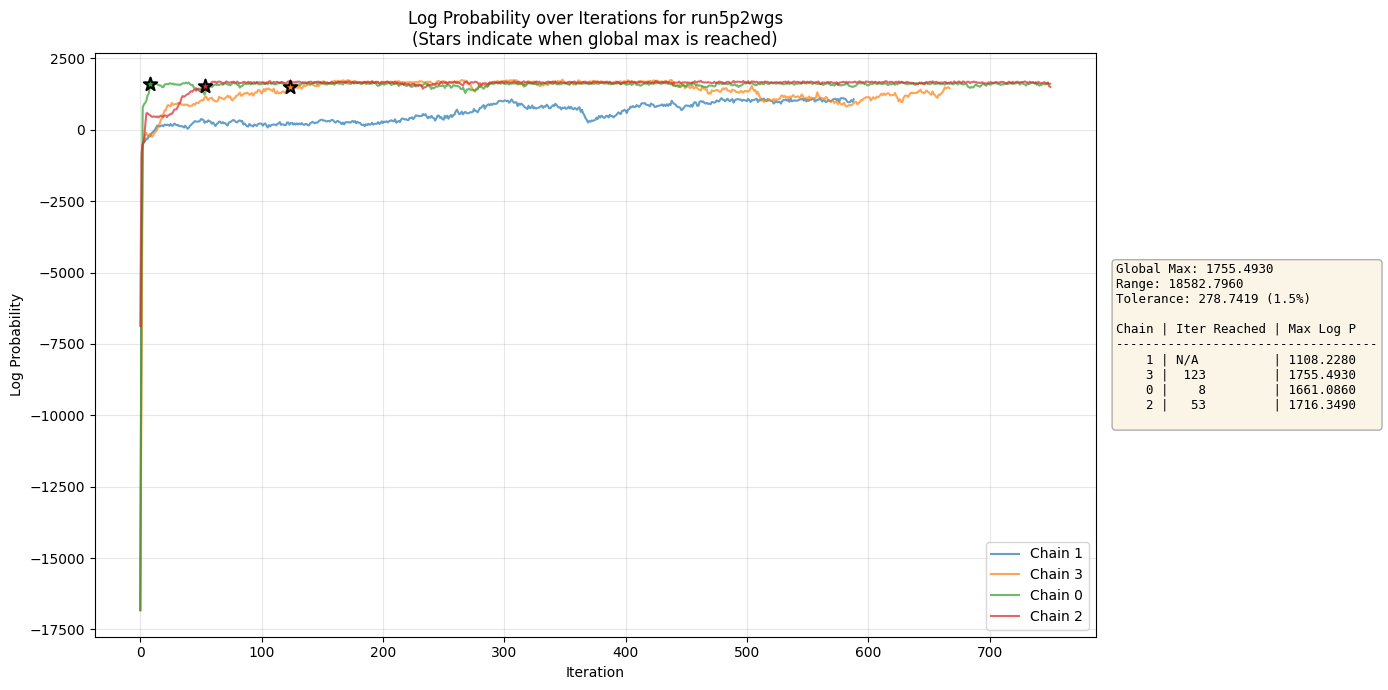

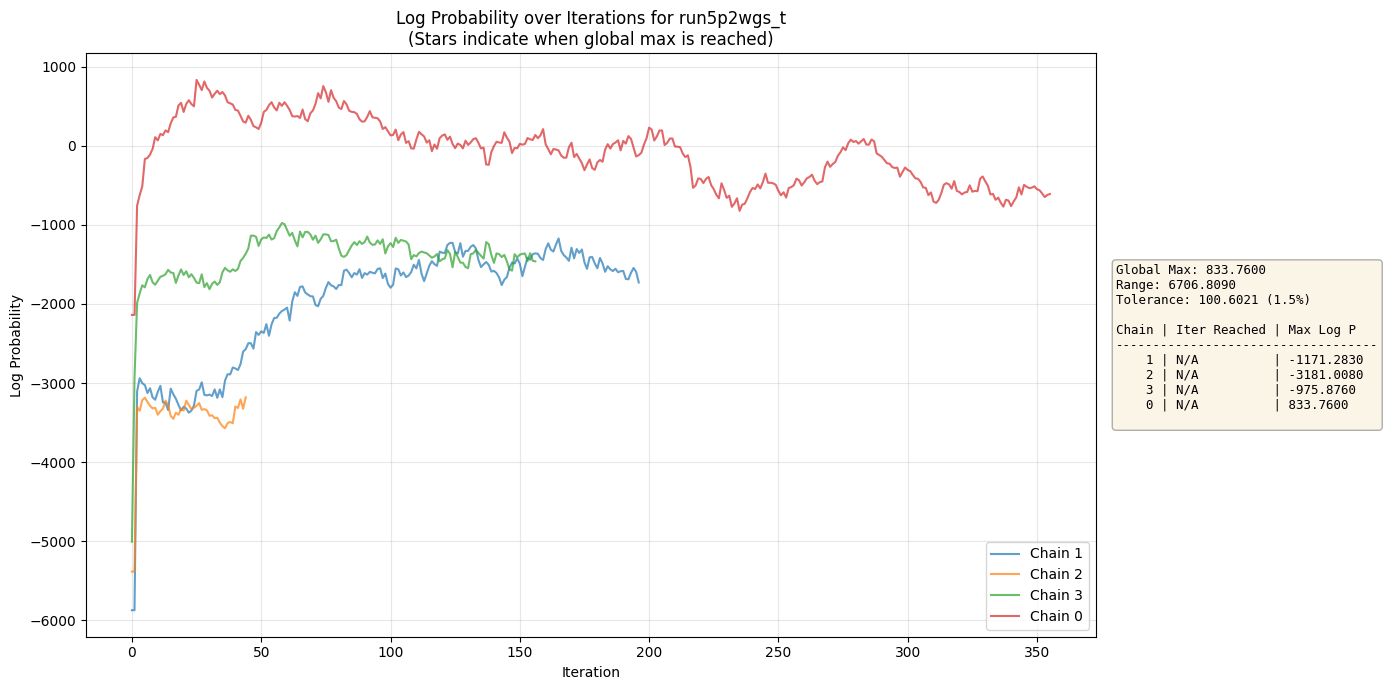

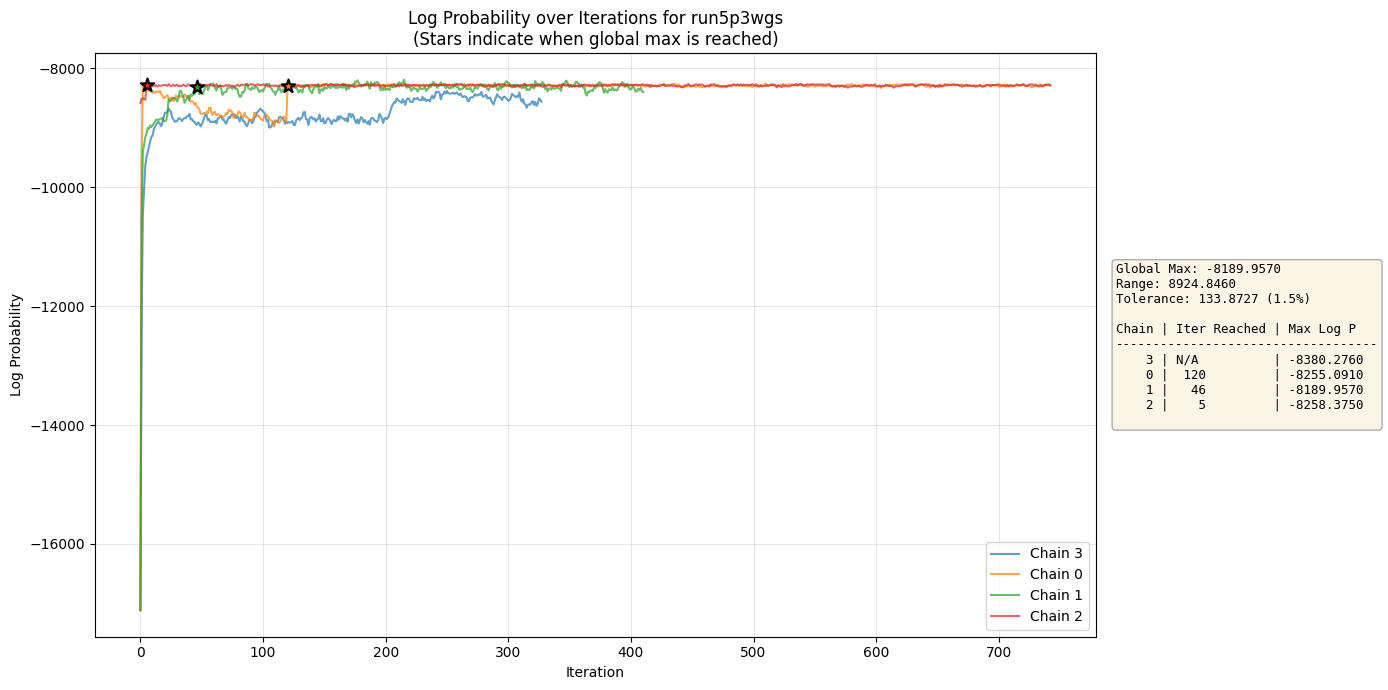

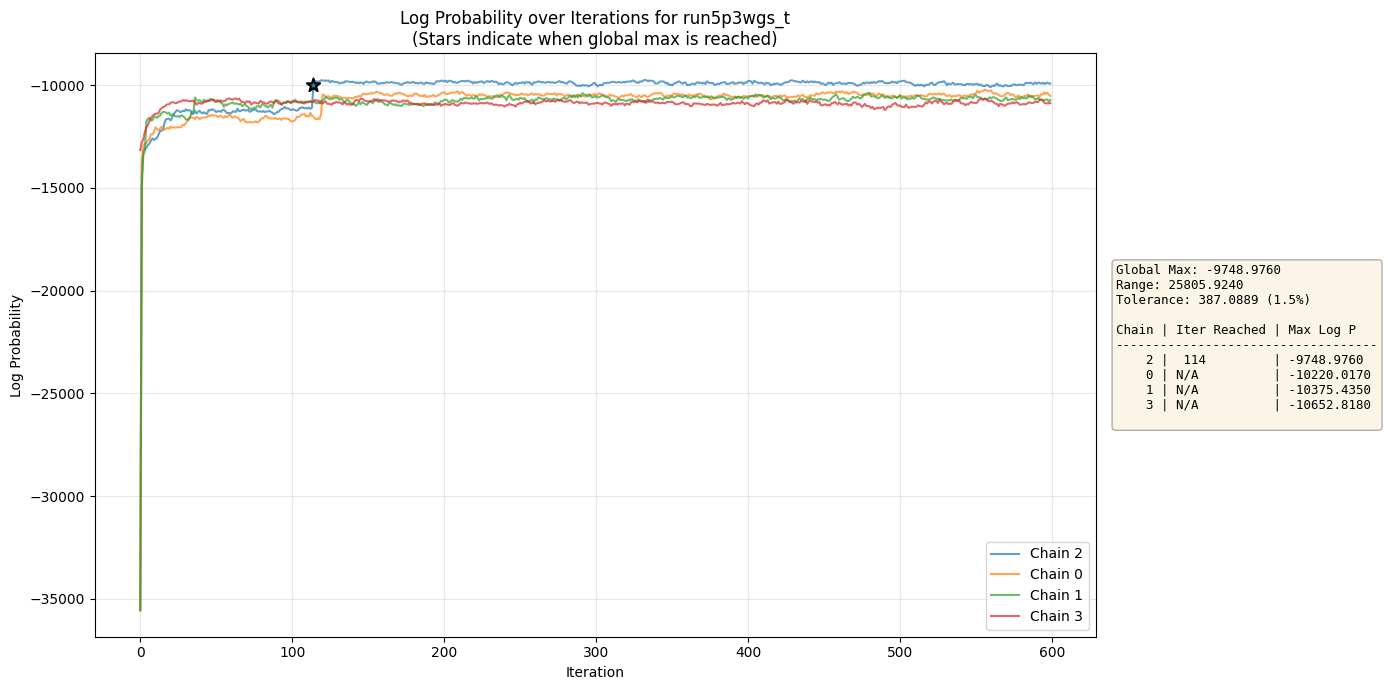

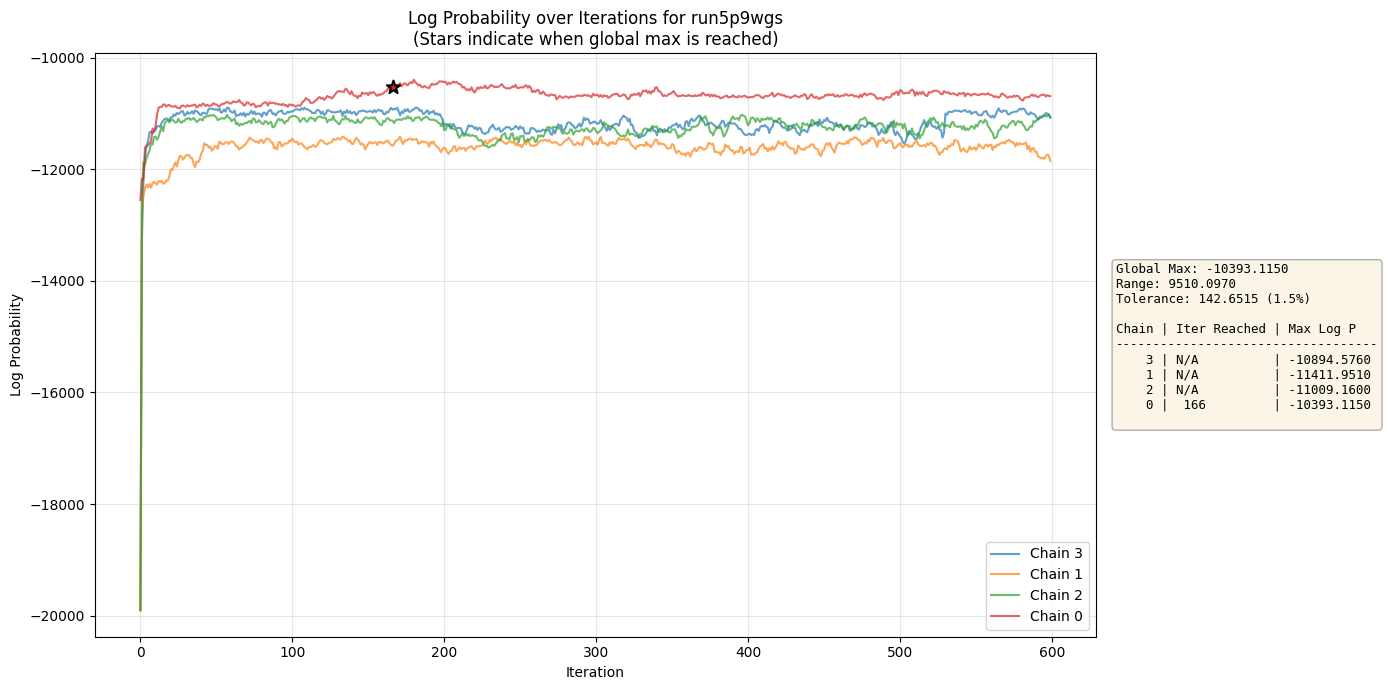

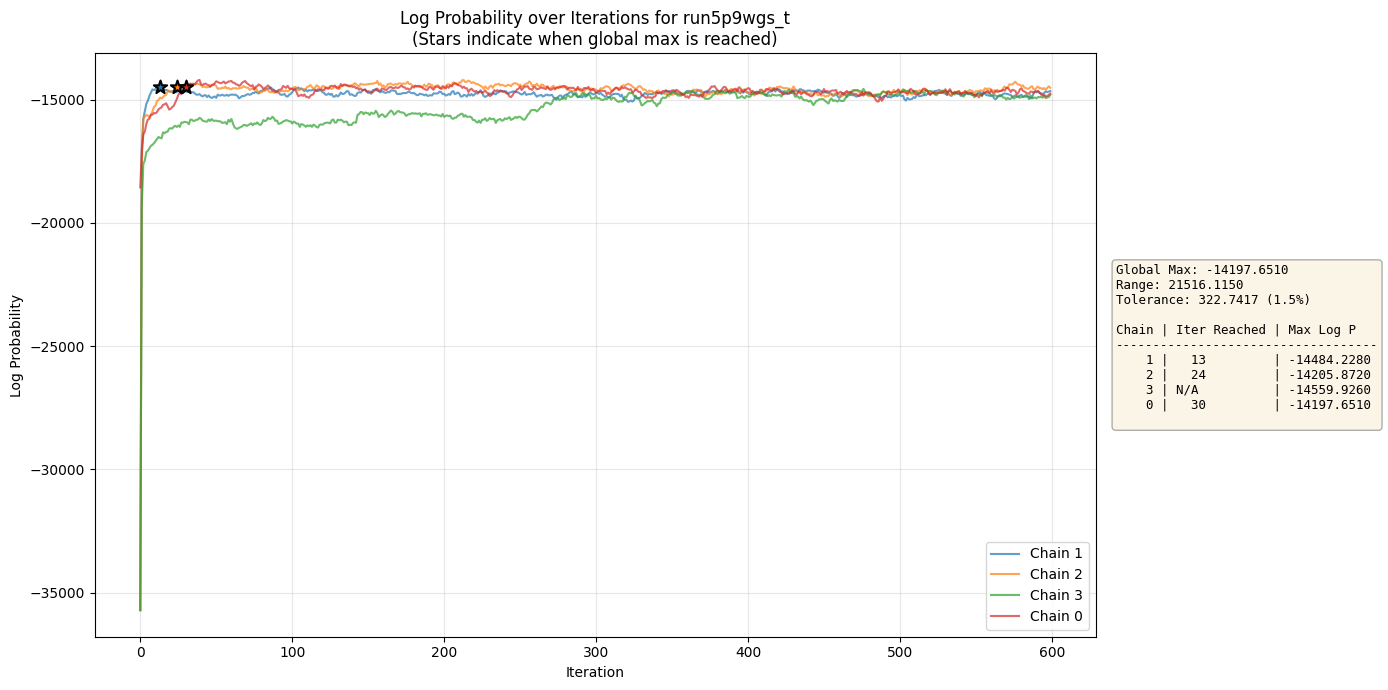

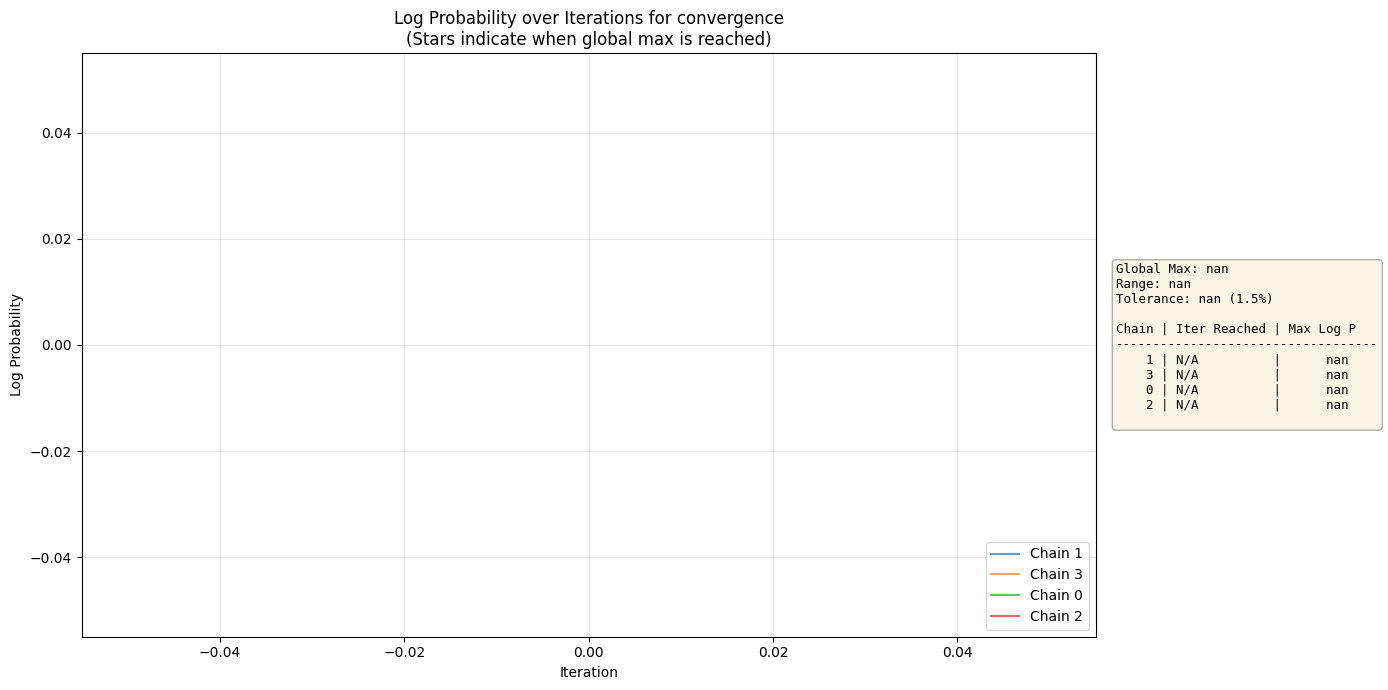

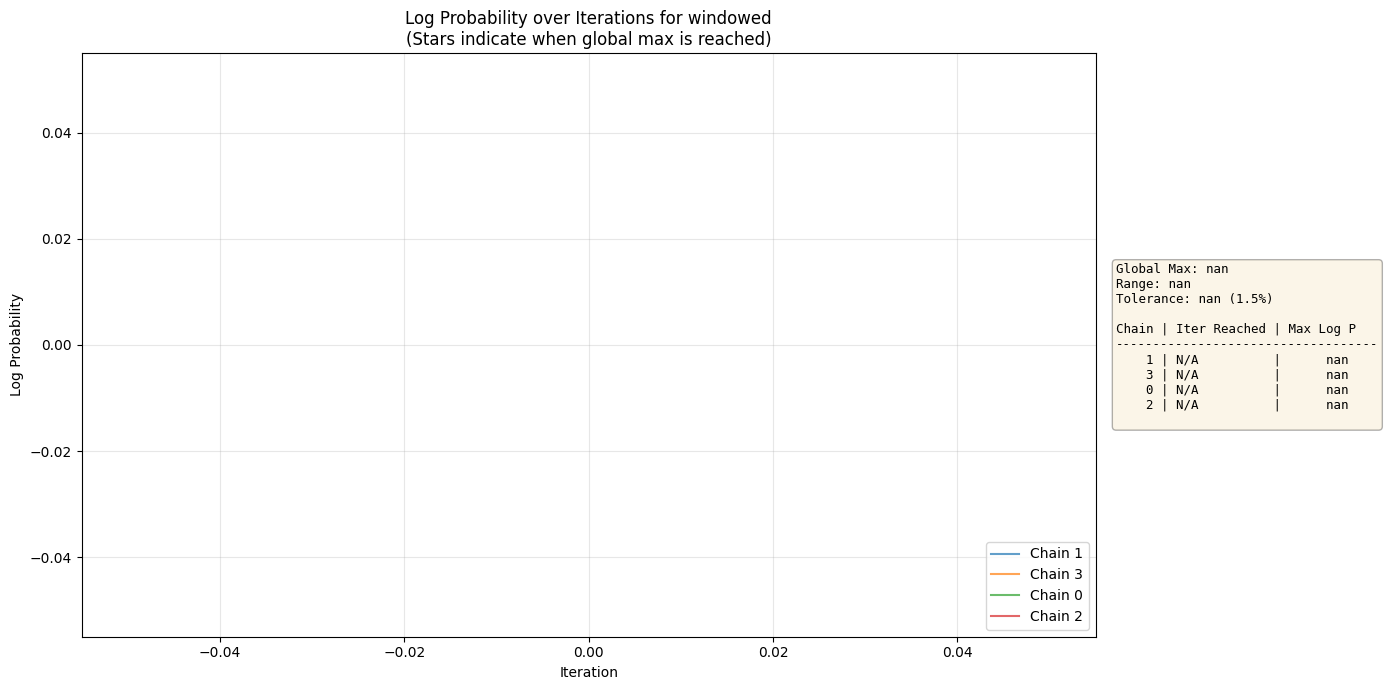

In [5]:
# Visualize when chains reach global maximum
for dataset in datasets:
    subset = data[data['dataset'] == dataset]
    subset_results = results_df[results_df['dataset'] == dataset]
    global_max = subset_results['global_max'].iloc[0]
    log_p_range = subset_results['log_p_range'].iloc[0]
    tolerance = abs(log_p_range * tolerance_ratio)
    
    plt.figure(figsize=(14, 7))
    
    # Plot log_p for each chain
    for chain in subset['chain'].unique():
        chain_data = subset[subset['chain'] == chain].sort_values('iter')
        line = plt.plot(chain_data['iter'], chain_data['log_p'], label=f'Chain {chain}', alpha=0.7)
        line_color = line[0].get_color()
        
        # Mark when chain reaches global maximum
        iter_reached = subset_results[subset_results['chain'] == chain]['iter_reached'].iloc[0]
        if iter_reached != -1:
            # Find the log_p value at that iteration
            log_p_at_reached = chain_data[chain_data['iter'] == iter_reached]['log_p'].iloc[0]
            plt.scatter(iter_reached, log_p_at_reached, s=100, marker='*', 
                       color=line_color, edgecolors='black', linewidths=1.5, zorder=5)
    
    # Create summary table text
    table_text = f"Global Max: {global_max:.4f}\n"
    table_text += f"Range: {log_p_range:.4f}\n"
    table_text += f"Tolerance: {tolerance:.4f} ({tolerance_ratio*100}%)\n\n"
    table_text += "Chain | Iter Reached | Max Log P\n"
    table_text += "-" * 35 + "\n"
    for _, row in subset_results.iterrows():
        status = "N/A" if row['iter_reached'] == -1 else f"{int(row['iter_reached']):4d}"
        table_text += f"{int(row['chain']):5d} | {status:12s} | {row['max_log_p']:8.4f}\n"    
    plt.text(1.02, 0.5, table_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3),
             family='monospace')
    
    plt.title(f'Log Probability over Iterations for {dataset}\n(Stars indicate when global max is reached)')
    plt.xlabel('Iteration')
    plt.ylabel('Log Probability')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/log_p_iterations_{dataset}.png')
    plt.show()

In [6]:
training_datasets = ['run5p2wgs', 'run5p2wgs_t', 'run5p3wgs', 'run5p3wgs_t', 'run5p9wgs']
test_datasets = ['run5p9wgs_t']

# Window configuration
MIN_WINDOW_SIZE = 20
MAX_WINDOW_SIZE = 1024
PADDING_VALUE = 0.0

In [7]:
# Create sliding window data with padding
def create_sliding_window_data(data, results_df, max_size=1024, min_size=20, padding_value=0.0):
    """
    Create sliding window sequences with padding.
    Each window starts at size min_size and grows by 1 until max_size.
    Windows are padded to max_size with padding_value.
    """
    windowed_data = []
    
    for dataset in data['dataset'].unique():
        subset = data[data['dataset'] == dataset]
        subset_results = results_df[results_df['dataset'] == dataset]
        
        for chain in subset['chain'].unique():
            chain_data = subset[subset['chain'] == chain].sort_values('iter')
            iter_reached = subset_results[subset_results['chain'] == chain]['iter_reached'].iloc[0]
            
            log_p_values = chain_data['log_p'].values
            iterations = chain_data['iter'].values
            
            # Create sliding windows starting from min_size
            for window_end in range(min_size, len(log_p_values) + 1):
                window_start = 0
                window_size = window_end
                
                # Extract the window
                window_log_p = log_p_values[window_start:window_end]
                current_iter = iterations[window_end - 1]
                
                # Pad to max_size
                padded_window = np.full(max_size, padding_value, dtype=np.float32)
                padded_window[:window_size] = window_log_p
                
                # Label: 0 if current iteration is before convergence, 1 if at/after convergence
                if iter_reached == -1:
                    label = 0
                elif current_iter < iter_reached:
                    label = 0
                else:
                    label = 1
                
                windowed_data.append({
                    'dataset': dataset,
                    'chain': chain,
                    'window_size': window_size,
                    'current_iter': current_iter,
                    'label': label,
                    'iter_reached': iter_reached,
                    'padded_sequence': padded_window
                })
    
    return windowed_data

print(f"Creating sliding window data (window size {MIN_WINDOW_SIZE} to {MAX_WINDOW_SIZE}, padded to {MAX_WINDOW_SIZE})...")
windowed_data = create_sliding_window_data(data, results_df, MAX_WINDOW_SIZE, MIN_WINDOW_SIZE, PADDING_VALUE)
print(f"Created {len(windowed_data)} windows")

# Create DataFrame for metadata (without sequences for easier viewing)
windowed_df = pd.DataFrame([{k: v for k, v in item.items() if k != 'padded_sequence'} for item in windowed_data])
windowed_df.to_csv('processed/windowed_data.csv', index=False)
windowed_df.head(20)

Creating sliding window data (window size 20 to 1024, padded to 1024)...
Created 12482 windows


,dataset,chain,window_size,current_iter,label,iter_reached
0,run5p2wgs,1,20,19.0,0,-1.0
1,run5p2wgs,1,21,20.0,0,-1.0
2,run5p2wgs,1,22,21.0,0,-1.0
3,run5p2wgs,1,23,22.0,0,-1.0
4,run5p2wgs,1,24,23.0,0,-1.0
5,run5p2wgs,1,25,24.0,0,-1.0
6,run5p2wgs,1,26,25.0,0,-1.0
7,run5p2wgs,1,27,26.0,0,-1.0
8,run5p2wgs,1,28,27.0,0,-1.0
9,run5p2wgs,1,29,28.0,0,-1.0


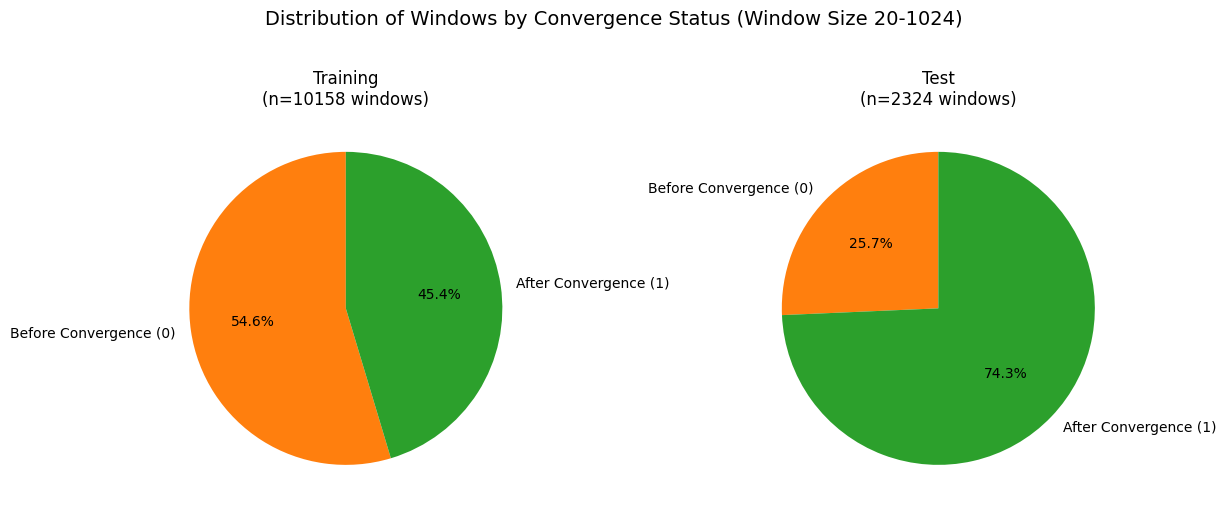

In [8]:
# Categorize datasets and calculate proportions
def categorize_dataset(dataset):
    if dataset in training_datasets:
        return 'Training'
    elif dataset in test_datasets:
        return 'Test'
    else:
        return 'Unknown'

windowed_df['category'] = windowed_df['dataset'].apply(categorize_dataset)

# Visualize proportions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, category in enumerate(['Training', 'Test']):
    cat_data = windowed_df[windowed_df['category'] == category]
    
    if len(cat_data) == 0:
        axes[idx].text(0.5, 0.5, 'No Data', ha='center', va='center')
        axes[idx].set_title(f'{category}')
        continue
    
    label_counts = cat_data['label'].value_counts().sort_index()
    colors = ['#ff7f0e', '#2ca02c']
    labels = ['Before Convergence (0)', 'After Convergence (1)']
    
    axes[idx].pie(label_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[idx].set_title(f'{category}\n(n={len(cat_data)} windows)')

plt.suptitle(f'Distribution of Windows by Convergence Status (Window Size {MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE})', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/window_proportions_by_category.png', bbox_inches='tight')
plt.show()

In [9]:
# Prepare sequences and labels from windowed data
sequences = np.array([item['padded_sequence'] for item in windowed_data])
labels = np.array([item['label'] for item in windowed_data])
metadata = [{k: v for k, v in item.items() if k != 'padded_sequence'} for item in windowed_data]

print(f"Sequences shape: {sequences.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")

Sequences shape: (12482, 1024)
Labels shape: (12482,)
Label distribution: [6148 6334]


In [10]:
# Function to prepare and normalize data
def prepare_windowed_data():
    """Prepare and normalize windowed data"""
    windowed_df['category'] = windowed_df['dataset'].apply(categorize_dataset)
    
    # Split by category
    train_mask = windowed_df['category'] == 'Training'
    test_mask = windowed_df['category'] == 'Test'
    
    X_train = sequences[train_mask]
    y_train = labels[train_mask]
    X_test = sequences[test_mask]
    y_test = labels[test_mask]
    
    # Normalize per window (only non-padded values)
    X_train_norm = normalize_per_window(X_train)
    X_test_norm = normalize_per_window(X_test)
    
    return X_train_norm, y_train, X_test_norm, y_test

def normalize_per_window(X):
    """Normalize each sequence independently, ignoring padding"""
    X_norm = np.zeros_like(X)
    for i in range(len(X)):
        # Find non-padded values (assuming padding is 0.0)
        non_padded_mask = X[i] != PADDING_VALUE
        non_padded_values = X[i][non_padded_mask]
        
        if len(non_padded_values) > 0:
            mean = non_padded_values.mean()
            std = non_padded_values.std()
            
            if std > 0:
                X_norm[i][non_padded_mask] = (non_padded_values - mean) / std
            else:
                X_norm[i][non_padded_mask] = non_padded_values - mean
    
    return X_norm

print("Data preparation function defined for sliding windows")

Data preparation function defined for sliding windows


In [11]:
# Create PyTorch Dataset
class ConvergenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences).unsqueeze(1)  # Add channel dimension
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Define CNN + Transformer model for variable length sequences
class ConvergenceCNNTransformer(nn.Module):
    def __init__(self, input_size=1024, num_filters=32, kernel_size=3, dropout=0.3, 
                 transformer_heads=4, transformer_dim=128):
        super(ConvergenceCNNTransformer, self).__init__()
        
        # CNN layers for local feature extraction
        self.conv1 = nn.Conv1d(1, num_filters, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(num_filters)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(num_filters, num_filters*2, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_filters*2)
        
        # After pooling once, sequence length is input_size // 2
        seq_length_after_pool = input_size // 2
        
        # Project CNN features to transformer dimension
        self.cnn_to_transformer = nn.Linear(num_filters * 2, transformer_dim)
        
        # Single transformer encoder layer for capturing long-range dependencies
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=transformer_heads,
            dim_feedforward=transformer_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        self.dropout = nn.Dropout(dropout)
        
        # Global average pooling over sequence dimension
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Classification head
        self.fc1 = nn.Linear(transformer_dim, 64)
        self.fc2 = nn.Linear(64, 2)
    
    def forward(self, x):
        # CNN feature extraction
        # x shape: (batch, 1, seq_len)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # (batch, num_filters, seq_len//2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)  # (batch, num_filters*2, seq_len//2)
        
        # Reshape for transformer: (batch, seq_len//2, num_filters*2)
        x = x.transpose(1, 2)
        
        # Project to transformer dimension
        x = self.cnn_to_transformer(x)  # (batch, seq_len//2, transformer_dim)
        
        # Transformer encoding for long-range dependencies
        x = self.transformer_encoder(x)  # (batch, seq_len//2, transformer_dim)
        
        # Global average pooling over sequence
        x = x.transpose(1, 2)  # (batch, transformer_dim, seq_len//2)
        x = self.global_pool(x).squeeze(-1)  # (batch, transformer_dim)
        
        # Classification
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("CNN + Transformer model architecture defined for sliding windows")

CNN + Transformer model architecture defined for sliding windows


In [12]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=50, device='cpu'):
    model.to(device)
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')
    
    return train_losses, train_accuracies

# Evaluation function
def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }

print("Training and evaluation functions defined")

Training and evaluation functions defined


Using device: cpu


Training: (10158, 1024), Test: (2324, 1024)
Training label distribution: [5551 4607]
Test label distribution: [ 597 1727]

Training with hyperparameters:
  num_filters: 32
  kernel_size: 5
  dropout: 0.3
  learning_rate: 0.0001
  batch_size: 32
  transformer_heads: 4
  transformer_dim: 128
  num_epochs: 50

Model architecture:
ConvergenceCNNTransformer(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn_to_transformer): Linear(in_features=64, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(


Starting training for 50 epochs...


Epoch [10/50], Train Loss: 0.0542, Train Acc: 0.9824


Epoch [20/50], Train Loss: 0.0251, Train Acc: 0.9911


Epoch [30/50], Train Loss: 0.0138, Train Acc: 0.9956


Epoch [40/50], Train Loss: 0.0174, Train Acc: 0.9945


Epoch [50/50], Train Loss: 0.0115, Train Acc: 0.9949

Training complete!


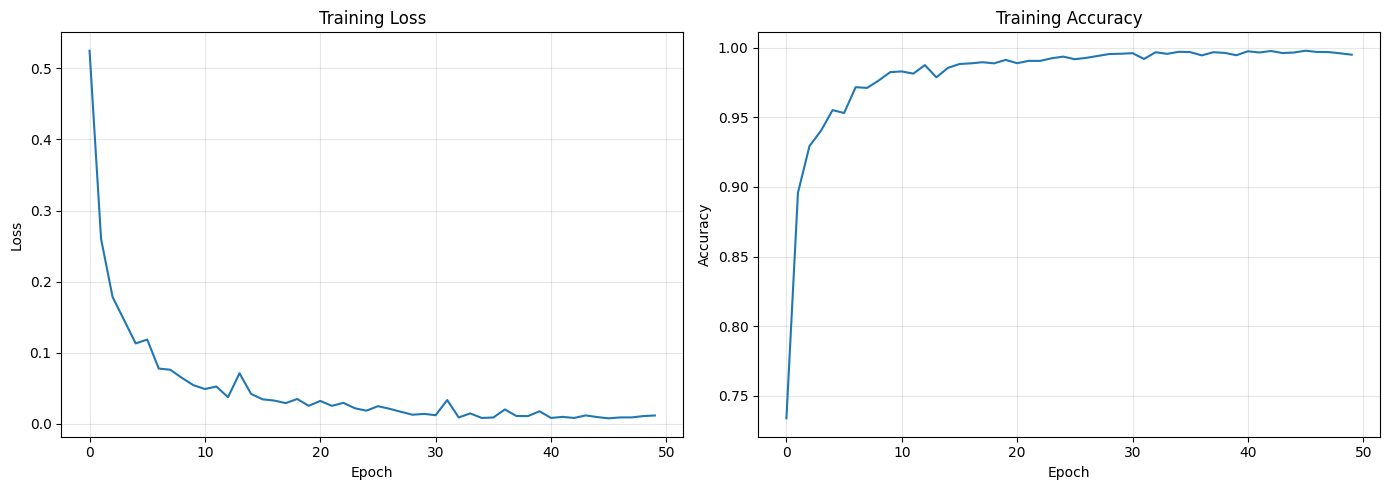

In [13]:
# Train CNN + Transformer model with selected hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Prepare data
X_train_norm, y_train, X_test_norm, y_test = prepare_windowed_data()
print(f"Training: {X_train_norm.shape}, Test: {X_test_norm.shape}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")

# Selected hyperparameters (based on typical best practices for CNN+Transformer)
params = {
    'num_filters': 32,
    'kernel_size': 5,
    'dropout': 0.3,
    'learning_rate': 0.0001,
    'batch_size': 32,
    'transformer_heads': 4,
    'transformer_dim': 128,
    'num_epochs': 50
}

print(f"\nTraining with hyperparameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

# Create data loaders
train_dataset = ConvergenceDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

# Create model
model = ConvergenceCNNTransformer(
    input_size=MAX_WINDOW_SIZE,
    num_filters=params['num_filters'],
    kernel_size=params['kernel_size'],
    dropout=params['dropout'],
    transformer_heads=params['transformer_heads'],
    transformer_dim=params['transformer_dim']
)

print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

# Train
print(f"\nStarting training for {params['num_epochs']} epochs...")
train_losses, train_accs = train_model(
    model, train_loader, criterion, optimizer,
    num_epochs=params['num_epochs'], device=device
)

print("\nTraining complete!")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/training_curves.png')
plt.show()


TEST SET RESULTS
Window Size Range: 20-1024
Accuracy:  0.2599
Precision: 0.5039
Recall:    0.2588
F1 Score:  0.3420

Confusion Matrix:
[[ 157  440]
 [1280  447]]


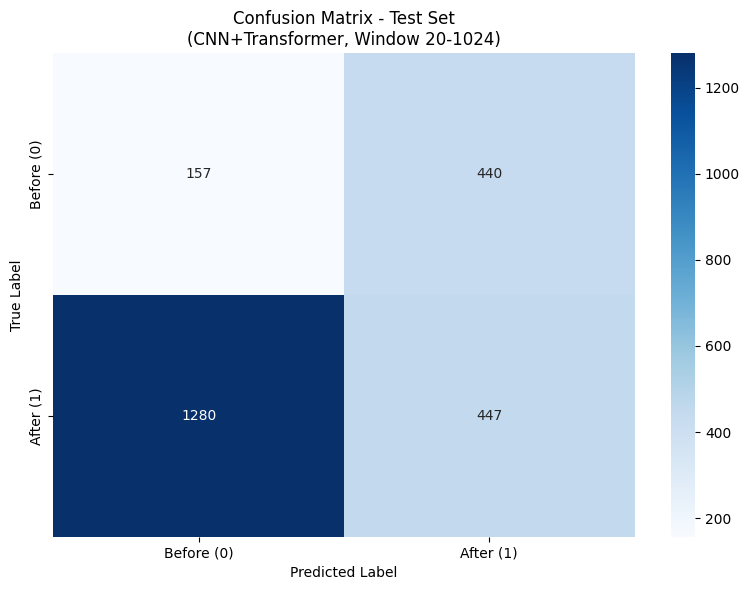


Model saved to models/best_convergence_cnn.pth
Hyperparameters: {'num_filters': 32, 'kernel_size': 5, 'dropout': 0.3, 'learning_rate': 0.0001, 'batch_size': 32, 'transformer_heads': 4, 'transformer_dim': 128, 'num_epochs': 50}


In [14]:
# Evaluate model on test set
test_dataset = ConvergenceDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

test_results = evaluate_model(model, test_loader, device=device)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Window Size Range: {MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE}")
print(f"Accuracy:  {test_results['accuracy']:.4f}")
print(f"Precision: {test_results['precision']:.4f}")
print(f"Recall:    {test_results['recall']:.4f}")
print(f"F1 Score:  {test_results['f1']:.4f}")
print("\nConfusion Matrix:")
print(test_results['confusion_matrix'])

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Before (0)', 'After (1)'],
            yticklabels=['Before (0)', 'After (1)'])
plt.title(f'Confusion Matrix - Test Set\n(CNN+Transformer, Window {MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('plots/confusion_matrix_test.png')
plt.show()

# Save model
torch.save(model.state_dict(), 'models/best_convergence_cnn.pth')
print(f"\nModel saved to models/best_convergence_cnn.pth")
print(f"Hyperparameters: {params}")

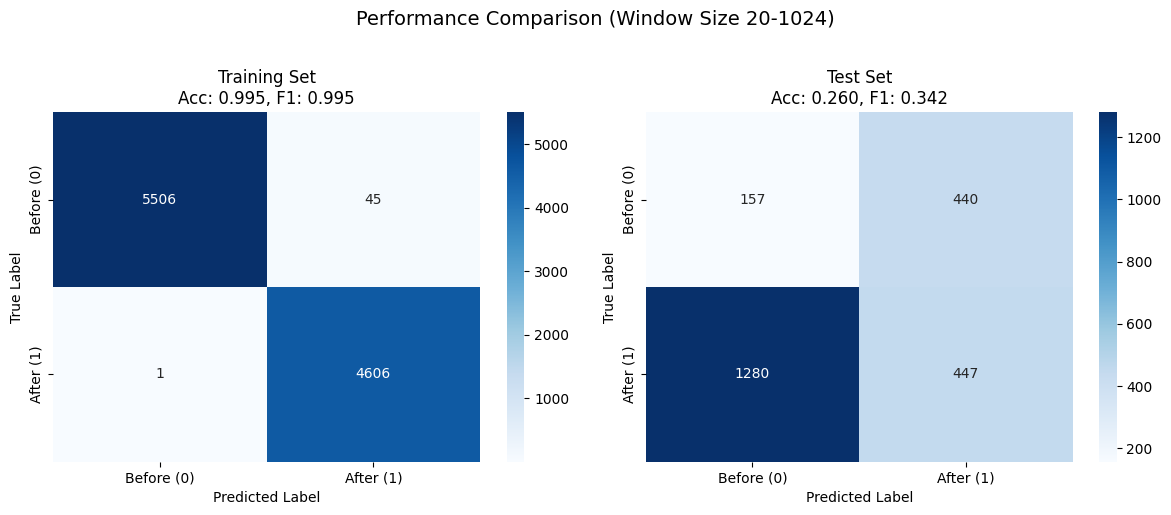


PERFORMANCE SUMMARY


,Dataset,Accuracy,Precision,Recall,F1 Score
0,Training,0.9955,0.9903,0.9998,0.9950
1,Test,0.2599,0.5039,0.2588,0.3420


In [15]:
# Compare performance on training vs test
train_dataset = ConvergenceDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=False)

train_results = evaluate_model(model, train_loader, device=device)

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sets = ['Training', 'Test']
results = [train_results, test_results]

for idx, (set_name, result) in enumerate(zip(sets, results)):
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Before (0)', 'After (1)'],
                yticklabels=['Before (0)', 'After (1)'],
                ax=axes[idx])
    axes[idx].set_title(f'{set_name} Set\nAcc: {result["accuracy"]:.3f}, F1: {result["f1"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.suptitle(f'Performance Comparison (Window Size {MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE})', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/confusion_matrices_all_sets.png')
plt.show()

# Summary table
summary_data = []
for set_name, result in zip(sets, results):
    summary_data.append({
        'Dataset': set_name,
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1 Score': f"{result['f1']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
summary_df

In [16]:
# Simulate real-time convergence prediction with sliding windows
def simulate_realtime_prediction(model, data, min_window_size, max_window_size, padding_value, device='cpu'):
    """
    Simulate running the CNN+Transformer model alongside the Bayesian optimization.
    For each chain, find the first iteration where the model predicts convergence (label=1).
    """
    model.eval()
    predictions_data = []
    
    datasets = data['dataset'].unique()
    
    for dataset in datasets:
        subset = data[data['dataset'] == dataset]
        
        for chain in subset['chain'].unique():
            chain_data = subset[subset['chain'] == chain].sort_values('iter')
            log_p_values = chain_data['log_p'].values
            
            predicted_convergence_iter = -1
            
            # Start from min_window_size and grow window by 1 each iteration
            for window_end in range(min_window_size, len(log_p_values) + 1):
                window_seq = log_p_values[:window_end]
                
                # Normalize this window independently
                window_mean = window_seq.mean()
                window_std = window_seq.std()
                if window_std > 0:
                    window_seq_norm = (window_seq - window_mean) / window_std
                else:
                    window_seq_norm = window_seq - window_mean
                
                # Pad to max_window_size
                padded_seq = np.full(max_window_size, padding_value, dtype=np.float32)
                padded_seq[:len(window_seq_norm)] = window_seq_norm
                
                # Prepare for model
                seq_tensor = torch.FloatTensor(padded_seq).unsqueeze(0).unsqueeze(0).to(device)
                
                # Predict
                with torch.no_grad():
                    output = model(seq_tensor)
                    _, predicted = torch.max(output.data, 1)
                    prediction = predicted.item()
                
                # If model predicts convergence (label=1), record this iteration
                if prediction == 1 and predicted_convergence_iter == -1:
                    predicted_convergence_iter = chain_data.iloc[window_end - 1]['iter'].item()
                    break
            
            predictions_data.append({
                'dataset': dataset,
                'chain': chain,
                'predicted_iter': predicted_convergence_iter
            })
    
    return pd.DataFrame(predictions_data)

print(f"Simulating real-time predictions with sliding window ({MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE})...")
realtime_predictions = simulate_realtime_prediction(
    model, data, MIN_WINDOW_SIZE, MAX_WINDOW_SIZE, PADDING_VALUE, device=device
)
realtime_predictions

Simulating real-time predictions with sliding window (20-1024)...


,dataset,chain,predicted_iter
0,run5p2wgs,1,-1.0
1,run5p2wgs,3,118.0
2,run5p2wgs,0,19.0
3,run5p2wgs,2,52.0
4,run5p2wgs_t,1,-1.0
5,run5p2wgs_t,2,-1.0
6,run5p2wgs_t,3,-1.0
7,run5p2wgs_t,0,-1.0
8,run5p3wgs,3,-1.0
9,run5p3wgs,0,120.0


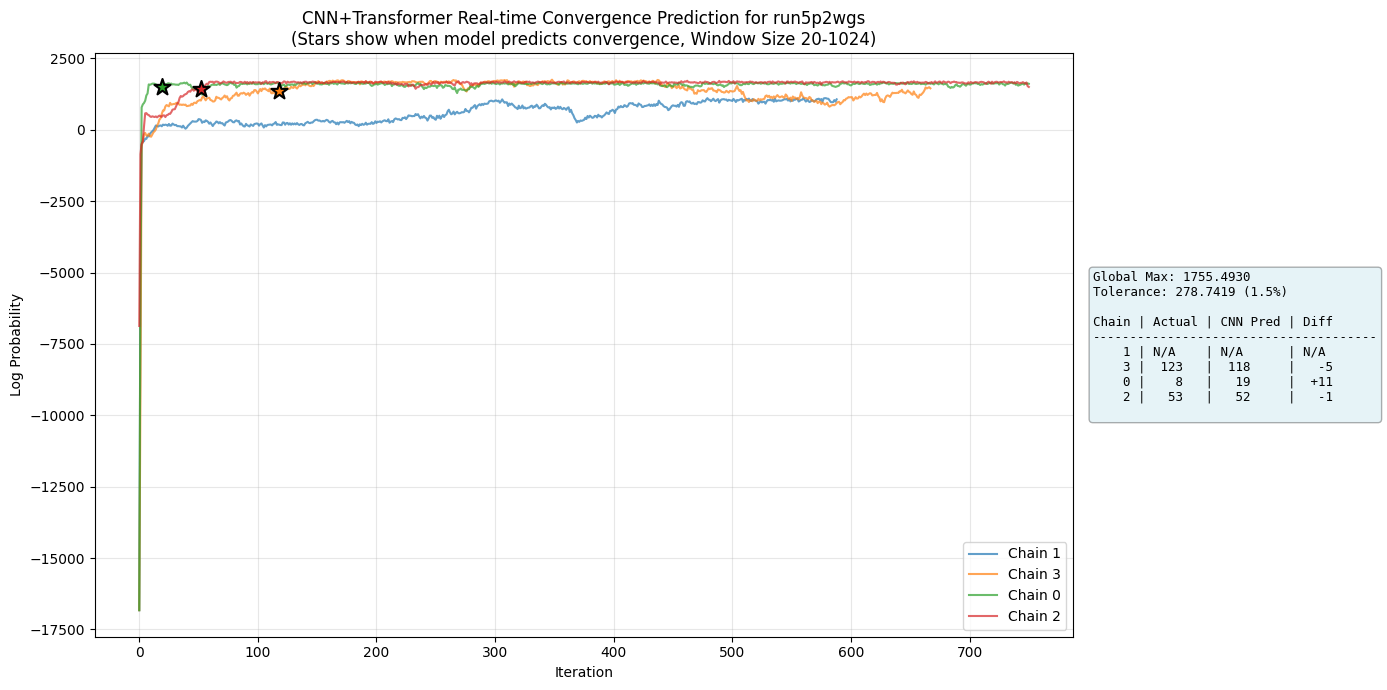

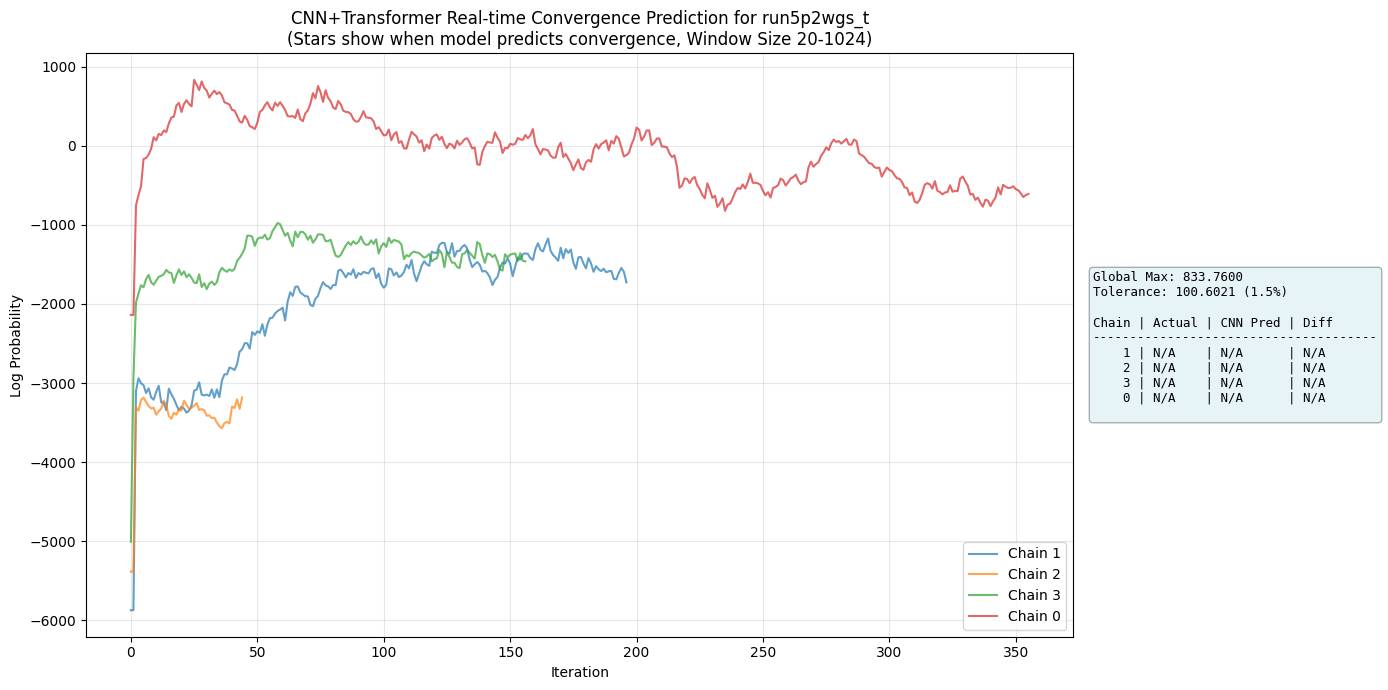

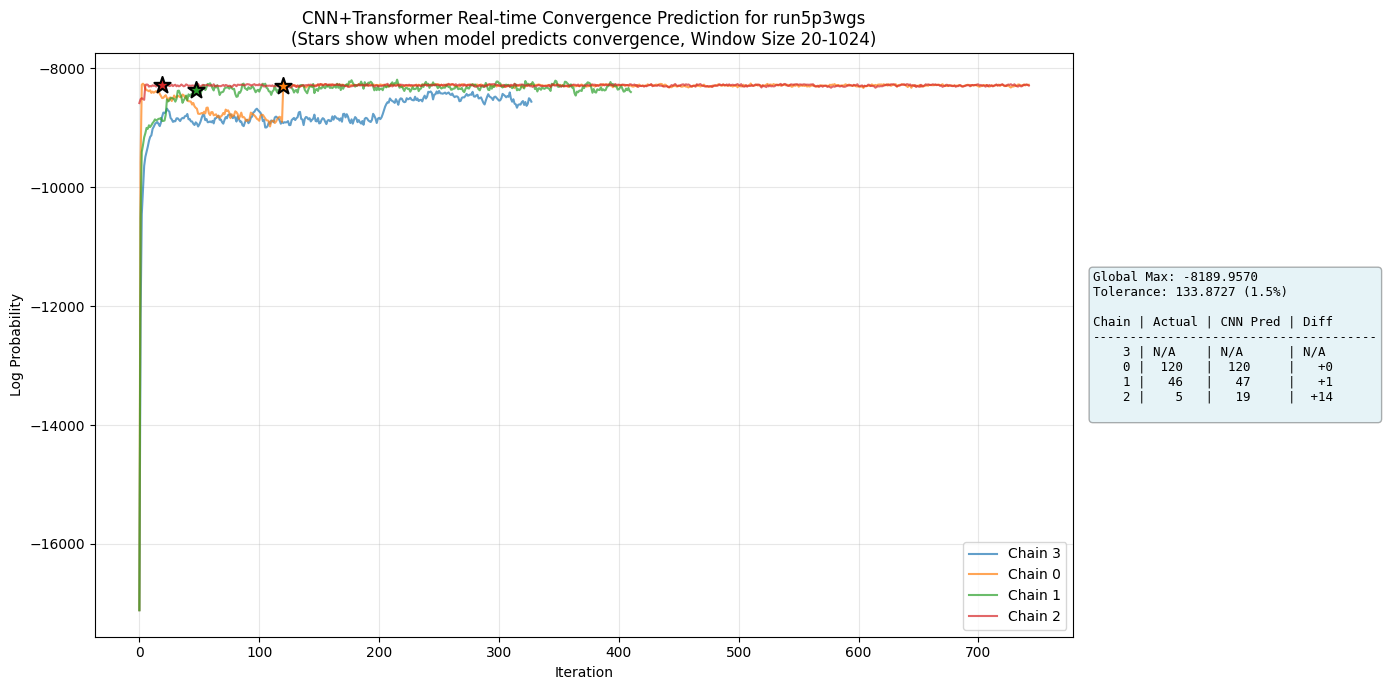

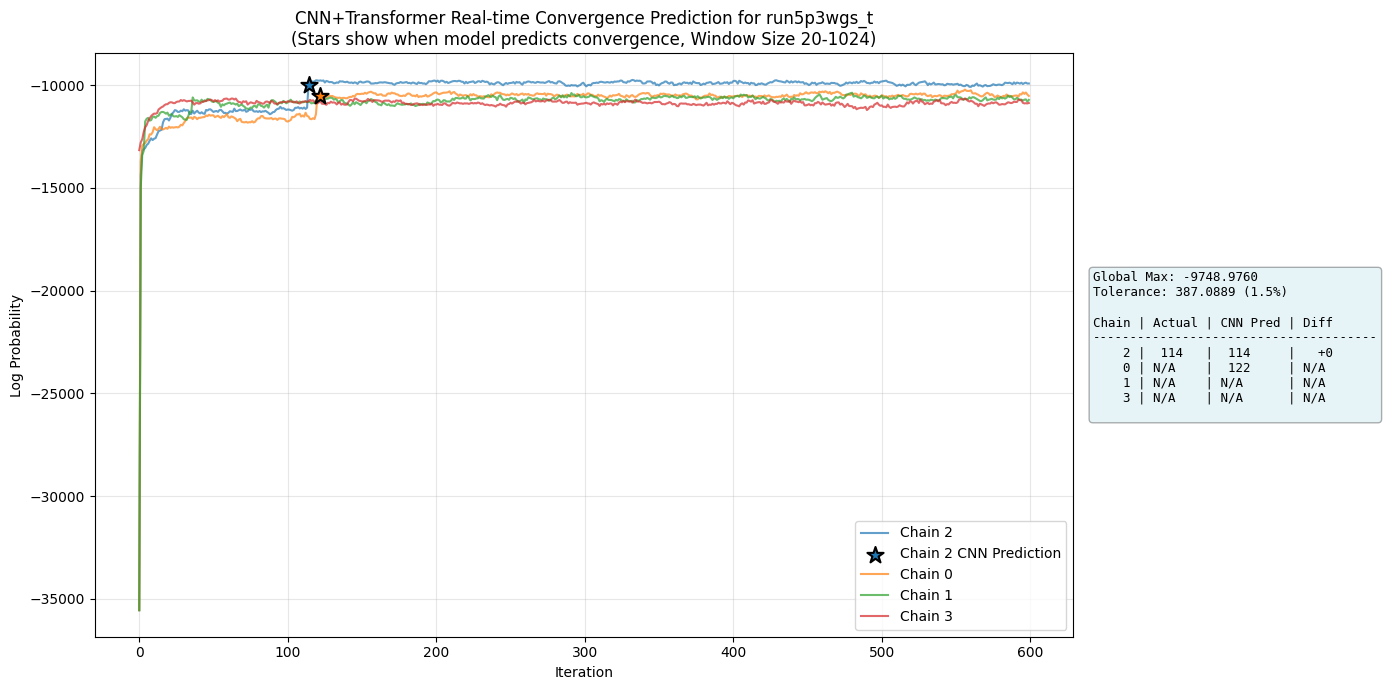

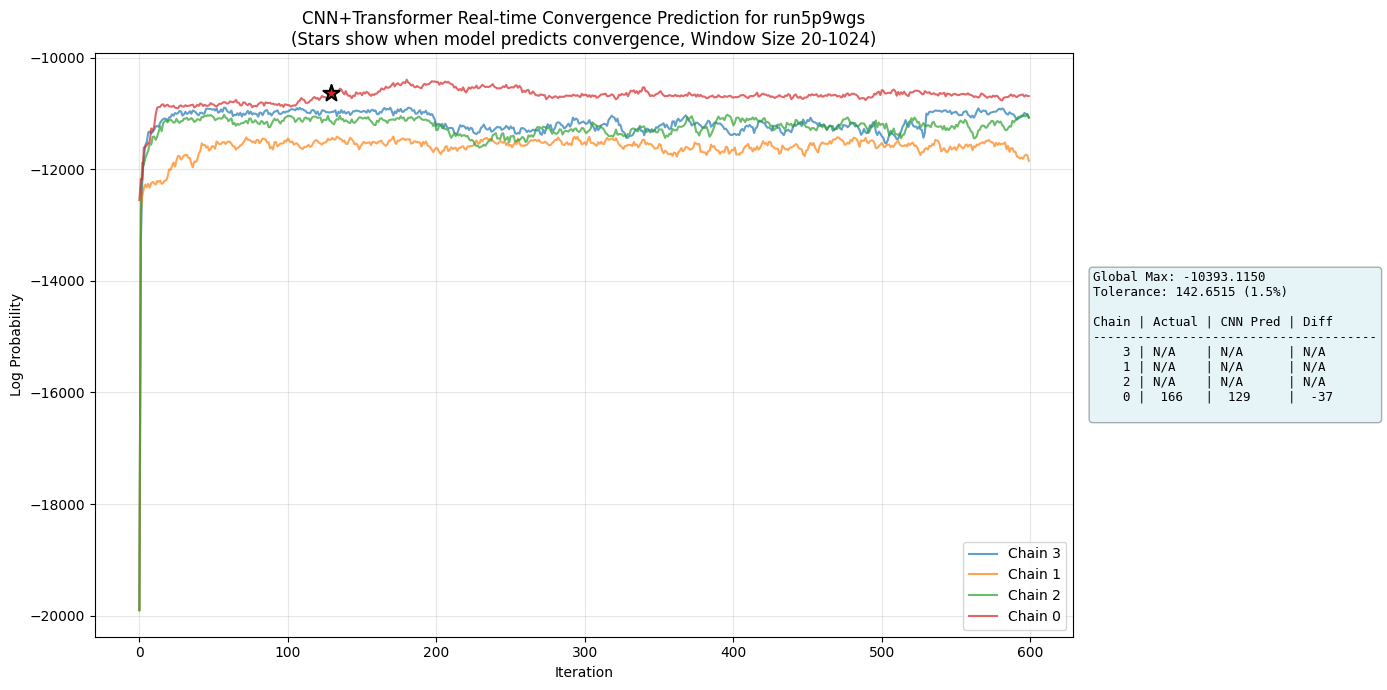

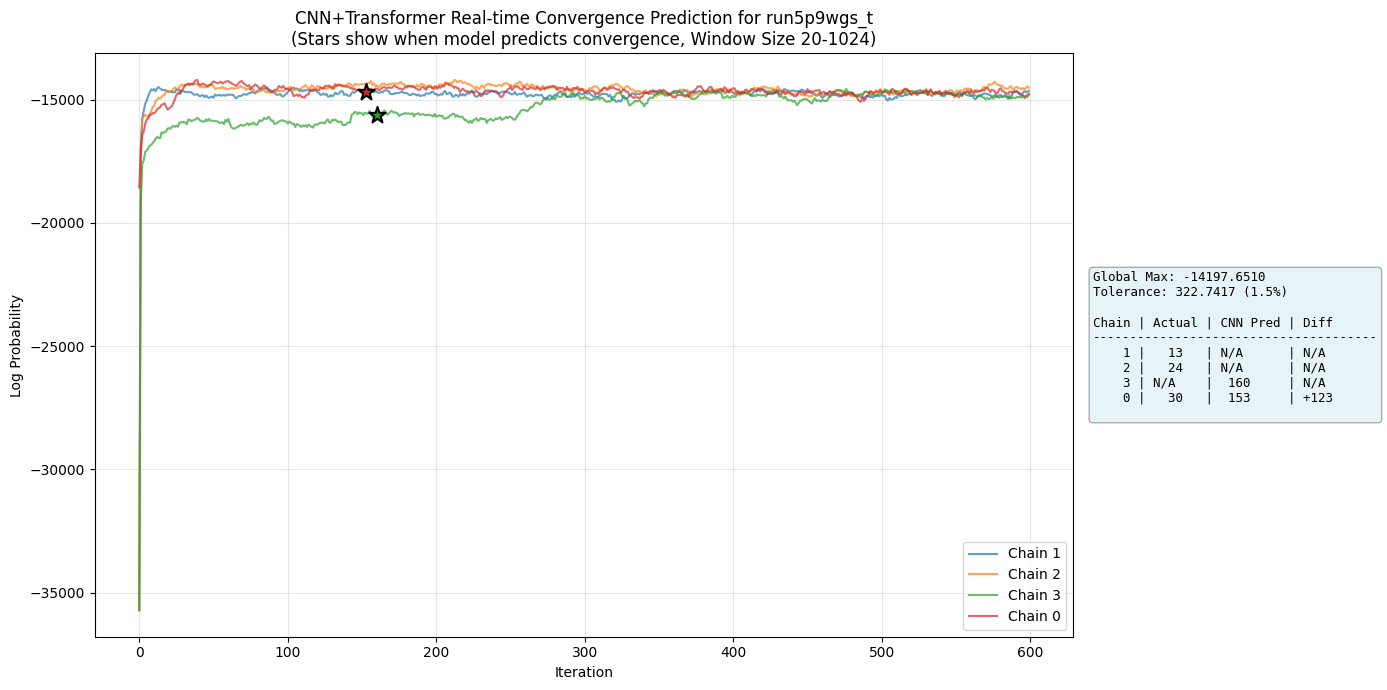

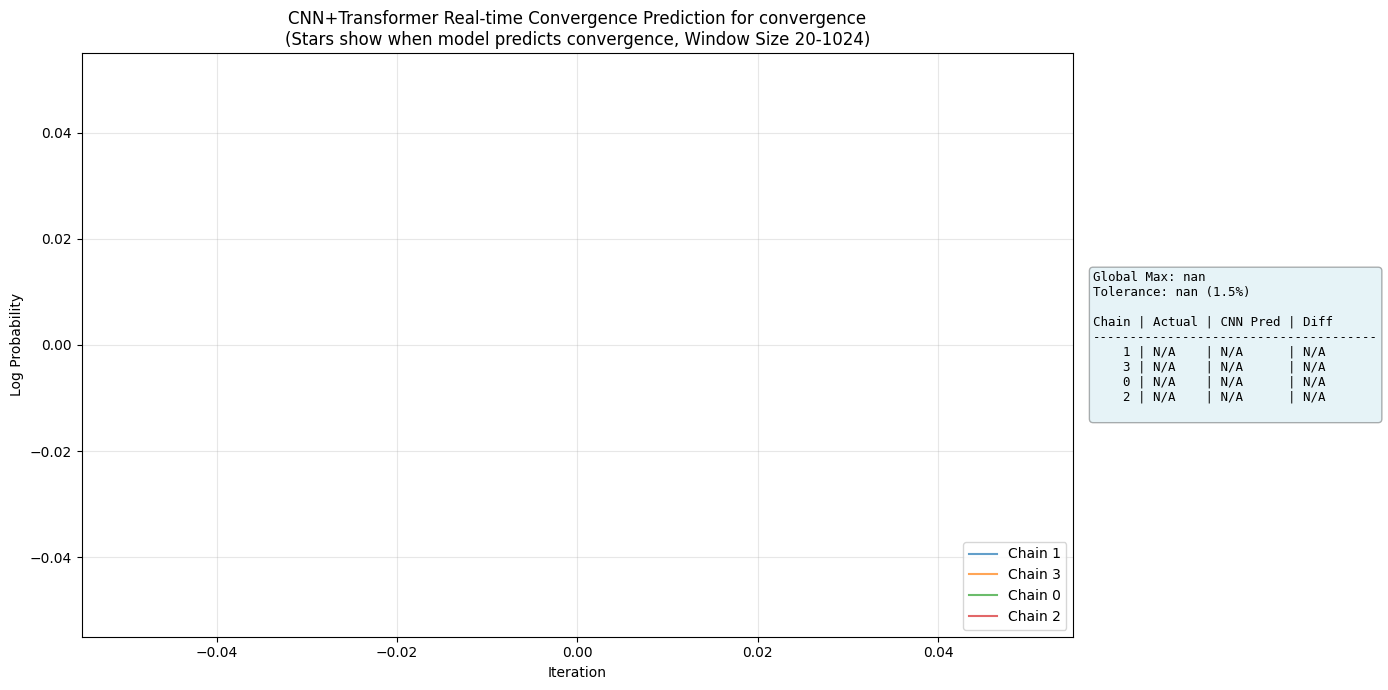

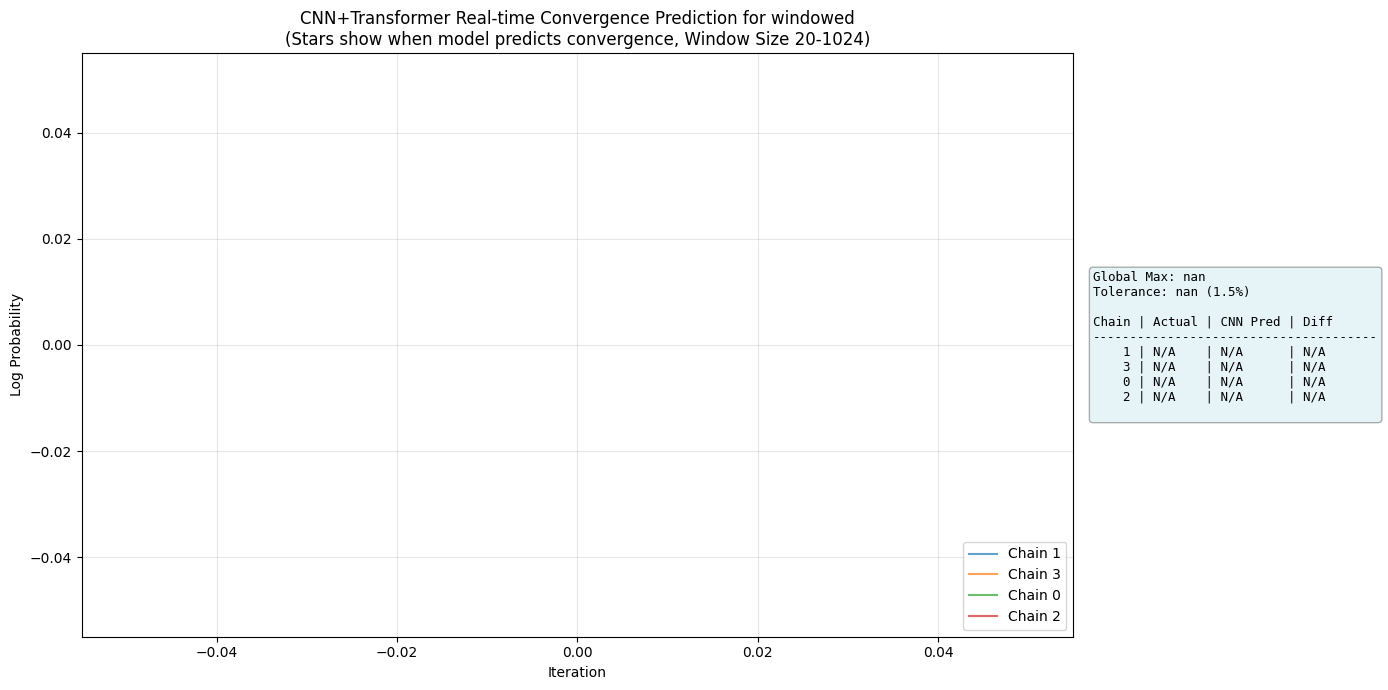

In [17]:
# Visualize predicted convergence vs actual convergence
for dataset in datasets:
    subset = data[data['dataset'] == dataset]
    convergence_results = results_df[results_df['dataset'] == dataset]
    subset_predictions = realtime_predictions[realtime_predictions['dataset'] == dataset]
    global_max = convergence_results['global_max'].iloc[0]
    log_p_range = convergence_results['log_p_range'].iloc[0]
    tolerance = abs(log_p_range * tolerance_ratio)
    
    plt.figure(figsize=(14, 7))
    
    # Plot log_p for each chain
    for chain in subset['chain'].unique():
        chain_data = subset[subset['chain'] == chain].sort_values('iter')
        line = plt.plot(chain_data['iter'], chain_data['log_p'], label=f'Chain {chain}', alpha=0.7)
        line_color = line[0].get_color()
        
        # Mark when CNN predicts convergence
        predicted_iter = subset_predictions[subset_predictions['chain'] == chain]['predicted_iter'].iloc[0]
        if predicted_iter != -1:
            # Find the log_p value at that iteration
            log_p_at_predicted = chain_data[chain_data['iter'] == predicted_iter]['log_p'].iloc[0]
            plt.scatter(predicted_iter, log_p_at_predicted, s=150, marker='*', 
                       color=line_color, edgecolors='black', linewidths=1.5, zorder=5,
                       label=f'Chain {chain} CNN Prediction' if chain == subset['chain'].unique()[0] else '')
    
    # Create summary table text comparing actual vs predicted
    table_text = f"Global Max: {global_max:.4f}\n"
    table_text += f"Tolerance: {tolerance:.4f} ({tolerance_ratio*100}%)\n\n"
    table_text += "Chain | Actual | CNN Pred | Diff\n"
    table_text += "-" * 38 + "\n"
    
    for _, row in convergence_results.iterrows():
        chain = int(row['chain'])
        actual_iter = row['iter_reached']
        predicted_iter = subset_predictions[subset_predictions['chain'] == chain]['predicted_iter'].iloc[0]
        
        actual_str = "N/A" if actual_iter == -1 else f"{int(actual_iter):4d}"
        pred_str = "N/A" if predicted_iter == -1 else f"{int(predicted_iter):4d}"
        
        if actual_iter == -1 or predicted_iter == -1:
            diff_str = "N/A"
        else:
            diff = int(predicted_iter - actual_iter)
            diff_str = f"{diff:+4d}"
        
        table_text += f"{chain:5d} | {actual_str:6s} | {pred_str:8s} | {diff_str:4s}\n"
    
    plt.text(1.02, 0.5, table_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3),
             family='monospace')
    
    plt.title(f'CNN+Transformer Real-time Convergence Prediction for {dataset}\n(Stars show when model predicts convergence, Window Size {MIN_WINDOW_SIZE}-{MAX_WINDOW_SIZE})')
    plt.xlabel('Iteration')
    plt.ylabel('Log Probability')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'plots/cnn_prediction_{dataset}.png')
    plt.show()

In [18]:
# Analyze prediction performance
# Merge actual and predicted convergence times
comparison_df = results_df[['dataset', 'chain', 'iter_reached']].merge(
    realtime_predictions, on=['dataset', 'chain'], how='left'
)
comparison_df['category'] = comparison_df['dataset'].apply(categorize_dataset)

# Calculate metrics
comparison_df['early_stop'] = comparison_df['predicted_iter'] < comparison_df['iter_reached']
comparison_df['missed'] = (comparison_df['predicted_iter'] == -1) & (comparison_df['iter_reached'] != -1)
comparison_df['correct_no_convergence'] = (comparison_df['predicted_iter'] == -1) & (comparison_df['iter_reached'] == -1)
comparison_df['iterations_saved'] = np.where(
    (comparison_df['iter_reached'] != -1) & (comparison_df['predicted_iter'] != -1),
    comparison_df['iter_reached'] - comparison_df['predicted_iter'],
    0
)

print("="*60)
print("CNN EARLY STOPPING ANALYSIS")
print("="*60)

for category in ['Training', 'Validation', 'Test']:
    cat_data = comparison_df[comparison_df['category'] == category]
    
    if len(cat_data) == 0:
        continue
    
    total_chains = len(cat_data)
    early_stops = cat_data['early_stop'].sum()
    missed = cat_data['missed'].sum()
    correct_no_conv = cat_data['correct_no_convergence'].sum()
    
    avg_iter_saved = cat_data[cat_data['iterations_saved'] > 0]['iterations_saved'].mean()
    
    print(f"\n{category}:")
    print(f"  Total chains: {total_chains}")
    print(f"  Early stops (CNN predicted before actual): {early_stops} ({early_stops/total_chains:.1%})")
    print(f"  Missed convergence: {missed} ({missed/total_chains:.1%})")
    print(f"  Correctly identified no convergence: {correct_no_conv}")
    if not np.isnan(avg_iter_saved):
        print(f"  Average iterations saved (when early stop): {avg_iter_saved:.1f}")

comparison_df.to_csv('processed/convergence_comparison.csv', index=False)
print("\n" + "="*60)
comparison_df

CNN EARLY STOPPING ANALYSIS

Training:
  Total chains: 20
  Early stops (CNN predicted before actual): 3 (15.0%)
  Missed convergence: 0 (0.0%)
  Correctly identified no convergence: 11
  Average iterations saved (when early stop): 14.3

Test:
  Total chains: 4
  Early stops (CNN predicted before actual): 2 (50.0%)
  Missed convergence: 2 (50.0%)
  Correctly identified no convergence: 0



,dataset,chain,iter_reached,predicted_iter,category,early_stop,missed,correct_no_convergence,iterations_saved
0,run5p2wgs,1,-1.0,-1.0,Training,False,False,True,0.0
1,run5p2wgs,3,123.0,118.0,Training,True,False,False,5.0
2,run5p2wgs,0,8.0,19.0,Training,False,False,False,-11.0
3,run5p2wgs,2,53.0,52.0,Training,True,False,False,1.0
4,run5p2wgs_t,1,-1.0,-1.0,Training,False,False,True,0.0
5,run5p2wgs_t,2,-1.0,-1.0,Training,False,False,True,0.0
6,run5p2wgs_t,3,-1.0,-1.0,Training,False,False,True,0.0
7,run5p2wgs_t,0,-1.0,-1.0,Training,False,False,True,0.0
8,run5p3wgs,3,-1.0,-1.0,Training,False,False,True,0.0
9,run5p3wgs,0,120.0,120.0,Training,False,False,False,0.0


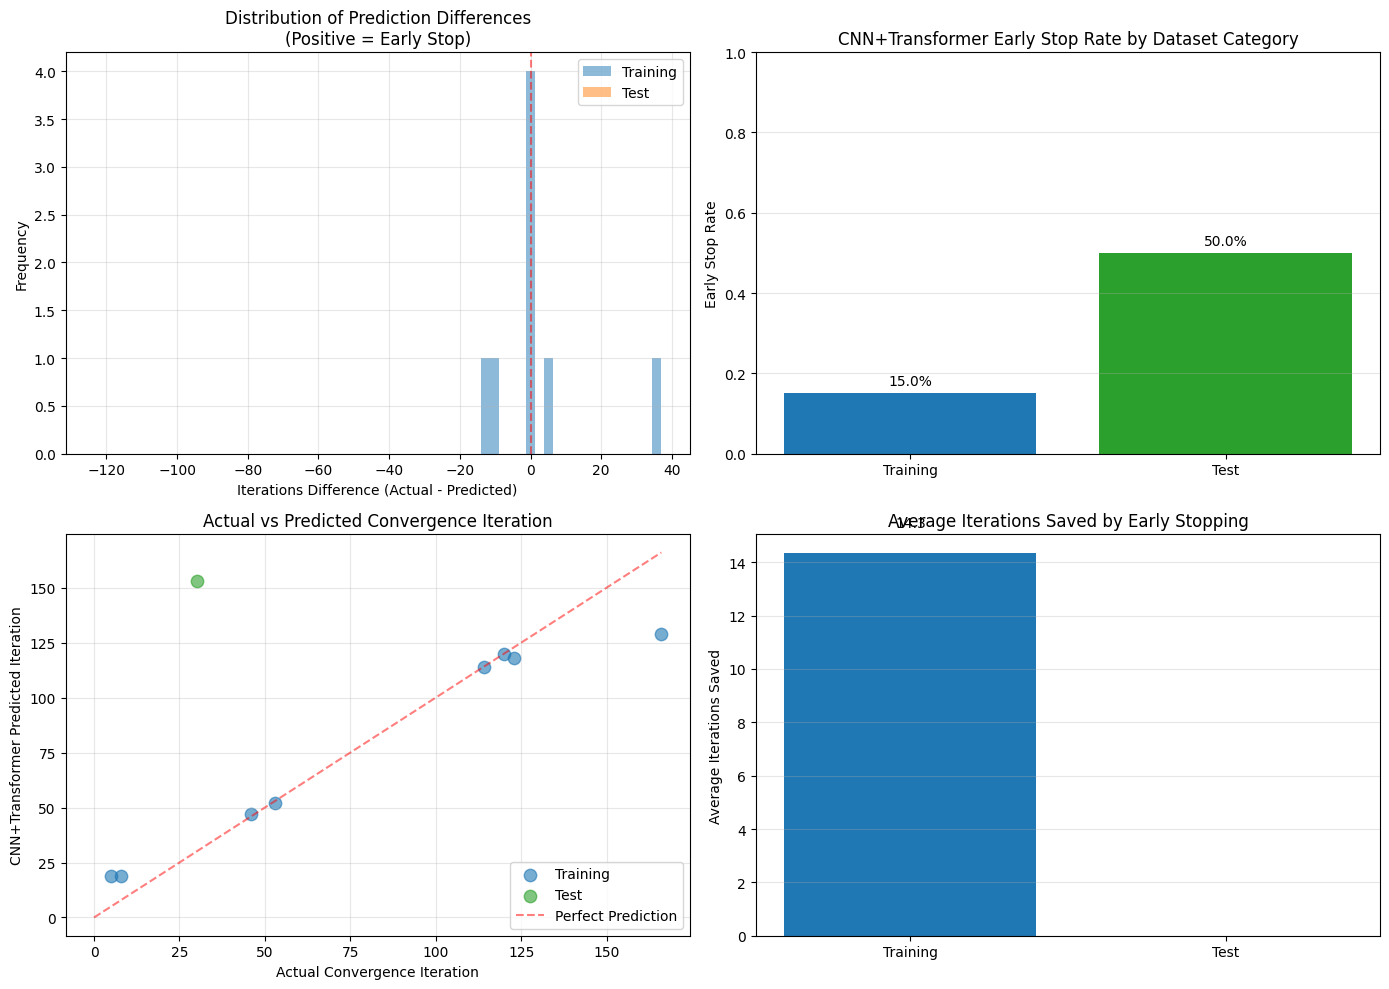

In [19]:
# Visualize comparison statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribution of prediction differences
for category in ['Training', 'Test']:
    cat_data = comparison_df[comparison_df['category'] == category]
    diffs = cat_data[
        (cat_data['iter_reached'] != -1) & 
        (cat_data['predicted_iter'] != -1)
    ]['iterations_saved']
    
    if len(diffs) > 0:
        axes[0, 0].hist(diffs, alpha=0.5, label=category, bins=20)

axes[0, 0].set_xlabel('Iterations Difference (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Differences\n(Positive = Early Stop)')
axes[0, 0].legend()
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(True, alpha=0.3)

# 2. Early stop rates by category
categories = ['Training', 'Test']
early_stop_rates = []
for cat in categories:
    cat_data = comparison_df[comparison_df['category'] == cat]
    if len(cat_data) > 0:
        rate = cat_data['early_stop'].sum() / len(cat_data)
        early_stop_rates.append(rate)
    else:
        early_stop_rates.append(0)

axes[0, 1].bar(categories, early_stop_rates, color=['#1f77b4', '#2ca02c'])
axes[0, 1].set_ylabel('Early Stop Rate')
axes[0, 1].set_title('CNN+Transformer Early Stop Rate by Dataset Category')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(early_stop_rates):
    axes[0, 1].text(i, v + 0.02, f'{v:.1%}', ha='center')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Scatter plot: Actual vs Predicted convergence iteration
for category, color in zip(['Training', 'Test'], ['#1f77b4', '#2ca02c']):
    cat_data = comparison_df[
        (comparison_df['category'] == category) &
        (comparison_df['iter_reached'] != -1) & 
        (comparison_df['predicted_iter'] != -1)
    ]
    if len(cat_data) > 0:
        axes[1, 0].scatter(cat_data['iter_reached'], cat_data['predicted_iter'], 
                          alpha=0.6, label=category, s=80, color=color)

max_iter = max(comparison_df[comparison_df['iter_reached'] != -1]['iter_reached'].max(),
               comparison_df[comparison_df['predicted_iter'] != -1]['predicted_iter'].max())
axes[1, 0].plot([0, max_iter], [0, max_iter], 'r--', alpha=0.5, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Convergence Iteration')
axes[1, 0].set_ylabel('CNN+Transformer Predicted Iteration')
axes[1, 0].set_title('Actual vs Predicted Convergence Iteration')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Average iterations saved by category
avg_saved = []
for cat in categories:
    cat_data = comparison_df[comparison_df['category'] == cat]
    saved = cat_data[cat_data['iterations_saved'] > 0]['iterations_saved'].mean()
    avg_saved.append(saved if not np.isnan(saved) else 0)

axes[1, 1].bar(categories, avg_saved, color=['#1f77b4', '#2ca02c'])
axes[1, 1].set_ylabel('Average Iterations Saved')
axes[1, 1].set_title('Average Iterations Saved by Early Stopping')
for i, v in enumerate(avg_saved):
    if v > 0:
        axes[1, 1].text(i, v + 1, f'{v:.1f}', ha='center')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('plots/cnn_early_stopping_analysis.png')
plt.show()